# Chapter 04: Custom Datasets
We've used some custom datasets before, how do we get our own data into pytorch?


In [1]:
import torch
from torch import nn

torch.__version__

'2.7.1'

In [46]:
import torch

# Set device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create tensors or models on the MPS device
x = torch.randn(4, 4).to(device)
x.device

device(type='mps', index=0)

## 1. Get data


In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    print(f"{image_path} does not exist, creating new one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(r.content)
# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data")
    zip_ref.extractall(image_path)


data/pizza_steak_sushi already exists
Unzipping data


## 2. Data prep and exploration

In [3]:
import os
def walk_through_dir(dir_path):
    # Walks through dir_path returing the contents
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are : {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [4]:
walk_through_dir(image_path)

There are : 2 directories and 0 images in data/pizza_steak_sushi
There are : 3 directories and 0 images in data/pizza_steak_sushi/test
There are : 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are : 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are : 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are : 3 directories and 0 images in data/pizza_steak_sushi/train
There are : 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are : 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are : 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


### 2.1 Visualizing an image
1. get all the image paths
2. Pick a random path using random.choice()
3. Get the class name using 'pathlib.Path.parent.stem'
4. Since we're working with images, lets open th pyhtons PIL
5. SHow image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


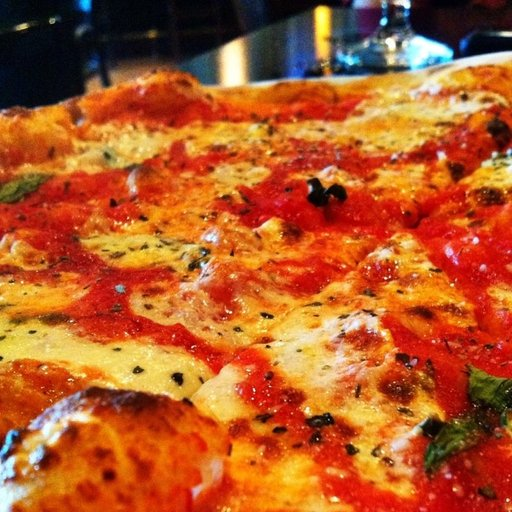

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42)
# 1. get all image paths
image_path_list =list(image_path.glob("*/*/*.jpg"))

# 2. Pick random image path
random_image_path = random.choice(image_path_list)

# 3.Get the image class from path name (the image class is the name of the directory where the image is stored_
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

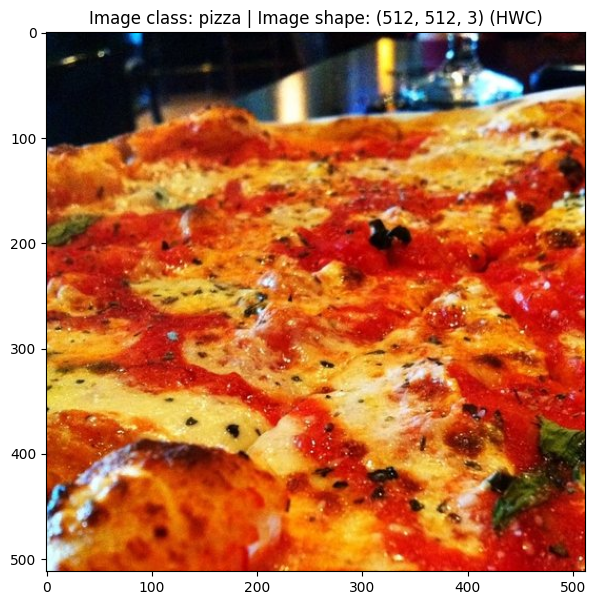

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} (HWC)")
plt.show()

## 3. Transforming data (jpg to tensors)
Images must be converted to tnesors before training!

In [8]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms


In [9]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the data
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [10]:
data_transform(img)

tensor([[[0.1020, 0.1922, 0.2314,  ..., 0.0118, 0.0157, 0.0157],
         [0.1216, 0.1059, 0.1137,  ..., 0.0157, 0.0157, 0.0157],
         [0.1569, 0.1255, 0.1098,  ..., 0.0941, 0.0235, 0.0157],
         ...,
         [0.6902, 0.6353, 0.4353,  ..., 0.8039, 0.8275, 0.8549],
         [0.7412, 0.6235, 0.4824,  ..., 0.7922, 0.8392, 0.8667],
         [0.8000, 0.6549, 0.6627,  ..., 0.7255, 0.7333, 0.8627]],

        [[0.0392, 0.0471, 0.0510,  ..., 0.0392, 0.0510, 0.0588],
         [0.0549, 0.0431, 0.0431,  ..., 0.0431, 0.0471, 0.0549],
         [0.0510, 0.0471, 0.0510,  ..., 0.1176, 0.0706, 0.0667],
         ...,
         [0.0627, 0.0627, 0.1098,  ..., 0.8118, 0.8824, 0.9529],
         [0.2353, 0.0824, 0.0667,  ..., 0.6353, 0.8510, 0.9804],
         [0.3098, 0.0980, 0.0745,  ..., 0.3176, 0.5451, 0.9412]],

        [[0.0392, 0.0510, 0.0588,  ..., 0.0667, 0.0745, 0.1176],
         [0.0510, 0.0392, 0.0431,  ..., 0.0784, 0.0863, 0.1137],
         [0.0627, 0.0510, 0.0588,  ..., 0.1216, 0.0941, 0.

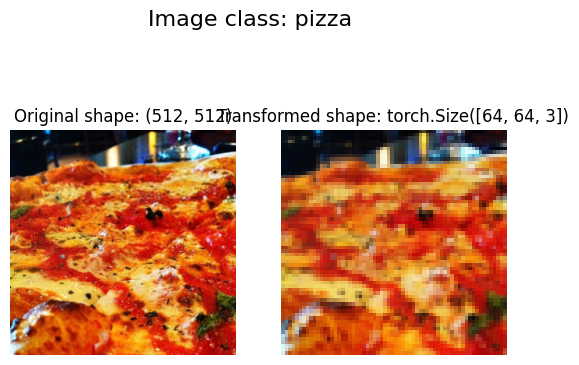

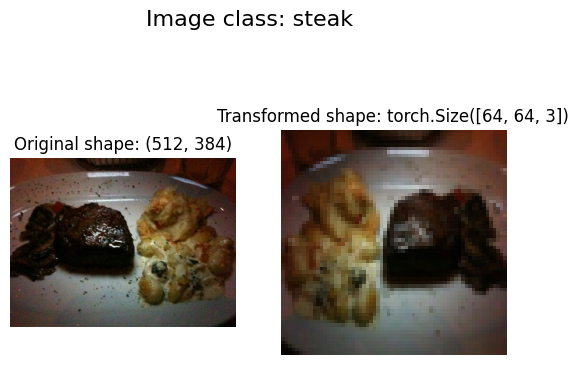

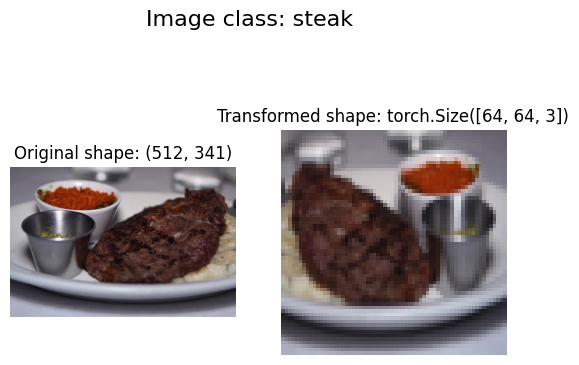

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed = 42):
    # Selects random images from a apath and transforms them, then plots the original vs transformed version
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original shape: {img.size}")
            ax[0].axis(False)

            # Transform and plot target iamge
            transformed_image = transform(img).permute(1, 2, 0) # (C, H, W)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed shape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list, data_transform, n=3, seed=42)

## 4. Option 1: Loading image data usig data folder
We can load image classification data using 'torchvision.datasets.ImageFolder'


In [12]:
# Using ImageFolder to create datasets(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target
train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get clas names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Check the lengths of the dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [16]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

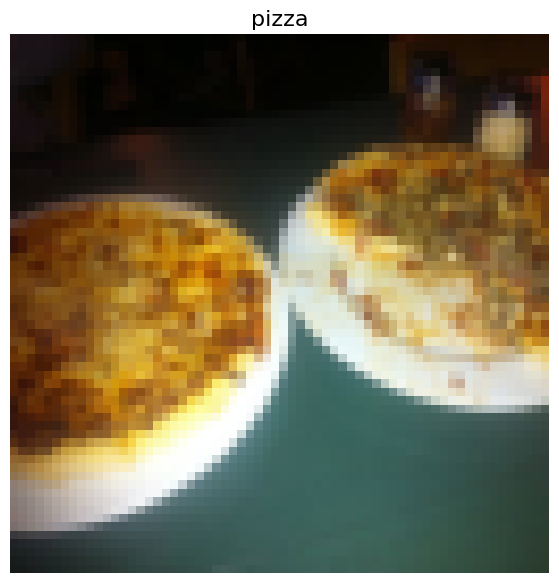

In [17]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=16)

## 4.1 Turn loaded images into 'DataLoader's'


In [18]:
import os
os.cpu_count()

8

In [41]:
#!nvidia-smi

# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
train_DataLoader = DataLoader(dataset=train_data,
                          batch_size=32,
                          num_workers=os.cpu_count(),
                          shuffle=True)
test_DataLoader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)


In [42]:
len(train_DataLoader), len(test_DataLoader)

(8, 3)

In [43]:
img, label = next(iter(train_DataLoader))

# Batch size will now be 1, you can now change the batch size if you want
print(f"Image shape: {img.shape} -> [Batch_size, color_channels, hieght, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [Batch_size, color_channels, hieght, width]
Label shape: torch.Size([32])


## 5. OPTION 2: LOADING IMAGE DATA WITH A CUSTOM 'DATASET'

Pros:
* Can create a dataset out of anything
* Not limited to Pytorches prebuilt dataset function
<br><br>Cons:
* Not all data will work
*





In [31]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [ ]:
# Instance of torchvision

In [44]:
print(torch.backends.mps.is_available())  # True if you can use Mac GPU
print(torch.backends.mps.is_built())      # True if PyTorch has MPS support


True
True


In [47]:
# Instance of trochvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})